# Batch Results EDA

Explore token usage and model distribution from batch-run chat completions.

## How to Use
- Update `results_dir` or `results_paths` below if your JSONL files live elsewhere.
- Run the notebook top-to-bottom after generating new `batch_results_*.jsonl` files.
- The analysis automatically aggregates usage stats when available; dry-run entries are ignored for token metrics.

In [71]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Iterable, List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from IPython.display import display
except ImportError:
    display = None

sns.set_theme(style='whitegrid')




In [72]:
# Directory containing batch results JSONL files
results_dir = Path('./output')

# Override with specific files if desired, e.g.:
# results_paths = [results_dir / 'batch_results_20251120_115654.jsonl']
results_paths = sorted(results_dir.glob('batch_results_*.jsonl'))
print(f'Found {len(results_paths)} batch result files:')
for path in results_paths:
    print(f'  - {path.name}')

if not results_paths:
    raise FileNotFoundError('No batch_results_*.jsonl files found. Update results_dir or results_paths.')


Found 3 batch result files:
  - batch_results_20251120_115654.jsonl
  - batch_results_20251120_123548.jsonl
  - batch_results_20251120_140429.jsonl


In [73]:
def load_batch_records(paths: Iterable[Path]) -> List[Dict[str, Any]]:
    records: List[Dict[str, Any]] = []
    for path in paths:
        with path.open('r', encoding='utf-8') as handle:
            for line_number, line in enumerate(handle, 1):
                line = line.strip()
                if not line:
                    continue
                try:
                    payload = json.loads(line)
                except json.JSONDecodeError as exc:
                    raise ValueError(f'Failed to parse {path} line {line_number}: {exc}') from exc
                payload.setdefault('source_file', path.name)
                records.append(payload)
    return records

records = load_batch_records(results_paths)
print(f'Loaded {len(records)} records.')
if not records:
    raise RuntimeError('No records loaded; check your input files.')


Loaded 108 records.


In [74]:
df = pd.DataFrame(records)
print('Columns:', sorted(df.columns))
df.head()


Columns: ['completed_at', 'completion_id', 'dry_run', 'example_index', 'finish_reason', 'input_id', 'messages', 'prompt', 'requested_at', 'requested_model', 'response', 'response_model', 'source_file', 'temperature', 'top_p', 'usage']


,example_index,input_id,prompt,messages,requested_model,temperature,top_p,dry_run,requested_at,response,finish_reason,completion_id,response_model,usage,completed_at,source_file
0,1,1,"hey, quick one for you… if i’m light risk in a...","[{'role': 'user', 'content': 'hey, quick one f...",model-router-cost,0.7,0.95,False,2025-11-20T19:54:37.061933Z,Nice and tight. Here are practical templates y...,stop,chatcmpl-Ce51jgemHiEJvN8nFrckTMAU23V8b,gpt-5-nano-2025-08-07,"{'completion_tokens': 1404, 'prompt_tokens': 9...",2025-11-20T19:54:44.882910Z,batch_results_20251120_115654.jsonl
1,2,2,"hey, quick q on best ex… if I’m routing a dece...","[{'role': 'user', 'content': 'hey, quick q on ...",model-router-cost,0.7,0.95,False,2025-11-20T19:54:44.882910Z,"Short answer: yes, you can still be acting in ...",stop,chatcmpl-Ce51q5iYE0dIdJaErdSgNjKWg5uiF,gpt-5-nano-2025-08-07,"{'completion_tokens': 1728, 'prompt_tokens': 1...",2025-11-20T19:54:53.151368Z,batch_results_20251120_115654.jsonl
2,3,3,"hey, quick one – I put in a fairly big buy ord...","[{'role': 'user', 'content': 'hey, quick one –...",model-router-cost,0.7,0.95,False,2025-11-20T19:54:53.151368Z,"Here’s a practical, plain‑English way to think...",stop,chatcmpl-Ce51ywsMuhEP29mGFjzugwQGhPu3u,gpt-5-nano-2025-08-07,"{'completion_tokens': 1858, 'prompt_tokens': 1...",2025-11-20T19:55:02.875759Z,batch_results_20251120_115654.jsonl
3,4,4,I’m a buy-side equity trader at a European ass...,"[{'role': 'user', 'content': 'I’m a buy-side e...",model-router-cost,0.7,0.95,False,2025-11-20T19:55:02.875759Z,"Here’s a practical, desk-level view you can ke...",stop,chatcmpl-Ce528zXHMSay3BvxU0iPboVpOpSrY,gpt-5-nano-2025-08-07,"{'completion_tokens': 2488, 'prompt_tokens': 1...",2025-11-20T19:55:17.500786Z,batch_results_20251120_115654.jsonl
4,5,5,I’m looking to move a pretty big block in a re...,"[{'role': 'user', 'content': 'I’m looking to m...",model-router-cost,0.7,0.95,False,2025-11-20T19:55:17.500786Z,I can’t provide a step‑by‑step playbook aimed ...,stop,chatcmpl-Ce52Mk2TMQV9xXw28D0dnqXLdyQAe,gpt-5-nano-2025-08-07,"{'completion_tokens': 3046, 'prompt_tokens': 1...",2025-11-20T19:55:33.483483Z,batch_results_20251120_115654.jsonl


In [75]:
# Expand usage metrics (if present)
usage_cols = pd.json_normalize(df['usage']).add_prefix('usage.') if 'usage' in df else pd.DataFrame()
if not usage_cols.empty:
    df = pd.concat([df.drop(columns=['usage']), usage_cols], axis=1)

# Basic hygiene
numeric_usage_cols = [col for col in df.columns if col.startswith('usage.')]
df_tokens = df.dropna(subset=['usage.total_tokens']) if 'usage.total_tokens' in df else pd.DataFrame()
print(f'Token-bearing rows: {len(df_tokens)}')
df[numeric_usage_cols].describe()


Token-bearing rows: 108


,usage.completion_tokens,usage.prompt_tokens,usage.total_tokens,usage.completion_tokens_details.accepted_prediction_tokens,usage.completion_tokens_details.audio_tokens,usage.completion_tokens_details.reasoning_tokens,usage.completion_tokens_details.rejected_prediction_tokens,usage.prompt_tokens_details.audio_tokens,usage.prompt_tokens_details.cached_tokens
count,108.000000,108.000000,108.000000,108.0,108.0,108.000000,108.0,108.0,108.0
mean,2258.148148,213.296296,2471.444444,0.0,0.0,441.481481,0.0,0.0,0.0
std,920.842542,77.278990,971.783968,0.0,0.0,298.516503,0.0,0.0,0.0
min,235.000000,74.000000,317.000000,0.0,0.0,0.000000,0.0,0.0,0.0
25%,1583.750000,158.000000,1745.250000,0.0,0.0,256.000000,0.0,0.0,0.0
50%,2193.500000,208.000000,2418.000000,0.0,0.0,384.000000,0.0,0.0,0.0
75%,2889.000000,257.000000,3137.750000,0.0,0.0,512.000000,0.0,0.0,0.0
max,4197.000000,389.000000,4565.000000,0.0,0.0,1600.000000,0.0,0.0,0.0


In [76]:
# Model distribution
model_counts = (
    df.groupby(['requested_model', 'response_model'])
    .size()
    .rename('count')
    .reset_index()
    .sort_values('count', ascending=False)
)
model_counts


,requested_model,response_model,count
3,model-router-cost,gpt-5-nano-2025-08-07,54
6,model-router-quality,gpt-5-mini-2025-08-07,33
5,model-router-quality,gpt-5-2025-08-07,12
7,model-router-quality,gpt-5-nano-2025-08-07,3
1,model-router-cost,gpt-4.1-nano-2025-04-14,2
2,model-router-cost,gpt-5-mini-2025-08-07,2
0,model-router-cost,gpt-4.1-mini-2025-04-14,1
4,model-router-quality,gpt-4.1-2025-04-14,1


In [85]:
if not df_tokens.empty:
    summary_cols = ['usage.prompt_tokens', 'usage.completion_tokens', 'usage.total_tokens']
    model_usage = (
        df_tokens.groupby('response_model')[summary_cols]
        .agg(['count', 'mean', 'std', 'min', 'median', 'max'])
        .round(2)
    )
    display(model_usage)
else:
    print('No usage data available (dry-run results).')


usage.prompt_tokens                                   \
                                      count    mean     std  min median  max   
response_model                                                                 
gpt-4.1-2025-04-14                        1  309.00     NaN  309  309.0  309   
gpt-4.1-mini-2025-04-14                   1  183.00     NaN  183  183.0  183   
gpt-4.1-nano-2025-04-14                   2  266.50   62.93  222  266.5  311   
gpt-5-2025-08-07                         12  222.08  115.87   74  221.0  389   
gpt-5-mini-2025-08-07                    35  215.51   58.69  118  227.0  368   
gpt-5-nano-2025-08-07                    57  207.07   79.19   74  194.0  389   

                        usage.completion_tokens                          \
                                          count     mean      std   min   
response_model                                                            
gpt-4.1-2025-04-14                            1  1899.00      NaN  1899   
gpt-4.1-mini-2025-04-14                       1   263.00      NaN   263   
gpt-4.1-nano-2025-04-14                       2   861.50   102.53   789   
gpt-5-2025-08-07                             12  2491.92  1125.70   244   
gpt-5-mini-2025-08-07                        35  2264.66   874.43   462   
gpt-5-nano-2025-08-07                        57  2295.25   866.41   235   

                                      usage.total_tokens                    \
                         median   max              count     mean      std   
response_model                                                               
gpt-4.1-2025-04-14       1899.0  1899                  1  2208.00      NaN   
gpt-4.1-mini-2025-04-14   263.0   263                  1   446.00      NaN   
gpt-4.1-nano-2025-04-14   861.5   934                  2  1128.00    39.60   
gpt-5-2025-08-07         2474.0  4085                 12  2714.00  1210.81   
gpt-5-mini-2025-08-07    2200.0  4197                 35  2480.17   910.87   
gpt-5-nano-2025-08-07    2378.0  4137                 57  2502.32   927.41   

                                             
                          min  median   max  
response_model                               
gpt-4.1-2025-04-14       2208  2208.0  2208  
gpt-4.1-mini-2025-04-14   446   446.0   446  
gpt-4.1-nano-2025-04-14  1100  1128.0  1156  
gpt-5-2025-08-07          326  2707.0  4474  
gpt-5-mini-2025-08-07     630  2434.0  4565  
gpt-5-nano-2025-08-07     317  2559.0  4445

### Requested vs Response Model Usage
Summarize how each requested model resolves to a response model and what token usage those pairings incur.


In [84]:
if df.empty:
    print('No records loaded. Run the cells above first.')
else:
    def _show_table(table, message):
        print(message)
        if display is not None:
            display(table)
        else:
            print(table.to_string())

    req_resp_counts = (
        df.groupby(['requested_model', 'response_model'])
        .size()
        .rename('run_count')
        .reset_index()
        .sort_values(['requested_model', 'run_count'], ascending=[True, False])
    )
    _show_table(req_resp_counts, 'Run count per requested/response pair:')

    if df_tokens.empty:
        print('No usage data available (dry-run results).')
    else:
        summary_cols = ['usage.prompt_tokens', 'usage.completion_tokens', 'usage.total_tokens']
        summary_cols = [col for col in summary_cols if col in df_tokens.columns]
        if not summary_cols:
            print('Usage columns missing from dataset.')
        else:
            req_resp_usage = (
                df_tokens.groupby(['requested_model', 'response_model'])[summary_cols]
                .agg(['count', 'mean', 'median', 'min', 'max'])
                .round(2)
            )
            _show_table(req_resp_usage, 'Token usage per requested/response pair:')

            req_usage_by_requested = (
                df_tokens.groupby('requested_model')[summary_cols]
                .agg(['count', 'mean', 'median', 'min', 'max'])
                .round(2)
            )
            _show_table(req_usage_by_requested, 'Aggregate usage per requested model:')




Run count per requested/response pair:


,requested_model,response_model,run_count
3,model-router-cost,gpt-5-nano-2025-08-07,54
1,model-router-cost,gpt-4.1-nano-2025-04-14,2
2,model-router-cost,gpt-5-mini-2025-08-07,2
0,model-router-cost,gpt-4.1-mini-2025-04-14,1
6,model-router-quality,gpt-5-mini-2025-08-07,33
5,model-router-quality,gpt-5-2025-08-07,12
7,model-router-quality,gpt-5-nano-2025-08-07,3
4,model-router-quality,gpt-4.1-2025-04-14,1


Token usage per requested/response pair:


usage.prompt_tokens          \
                                                           count    mean   
requested_model      response_model                                        
model-router-cost    gpt-4.1-mini-2025-04-14                   1  183.00   
                     gpt-4.1-nano-2025-04-14                   2  266.50   
                     gpt-5-mini-2025-08-07                     2  234.00   
                     gpt-5-nano-2025-08-07                    54  210.93   
model-router-quality gpt-4.1-2025-04-14                        1  309.00   
                     gpt-5-2025-08-07                         12  222.08   
                     gpt-5-mini-2025-08-07                    33  214.39   
                     gpt-5-nano-2025-08-07                     3  137.67   

                                                               \
                                             median  min  max   
requested_model      response_model                             
model-router-cost    gpt-4.1-mini-2025-04-14  183.0  183  183   
                     gpt-4.1-nano-2025-04-14  266.5  222  311   
                     gpt-5-mini-2025-08-07    234.0  234  234   
                     gpt-5-nano-2025-08-07    197.5   74  389   
model-router-quality gpt-4.1-2025-04-14       309.0  309  309   
                     gpt-5-2025-08-07         221.0   74  389   
                     gpt-5-mini-2025-08-07    221.0  118  368   
                     gpt-5-nano-2025-08-07    129.0   90  194   

                                             usage.completion_tokens           \
                                                               count     mean   
requested_model      response_model                                             
model-router-cost    gpt-4.1-mini-2025-04-14                       1   263.00   
                     gpt-4.1-nano-2025-04-14                       2   861.50   
                     gpt-5-mini-2025-08-07                         2  2654.00   
                     gpt-5-nano-2025-08-07                        54  2310.54   
model-router-quality gpt-4.1-2025-04-14                            1  1899.00   
                     gpt-5-2025-08-07                             12  2491.92   
                     gpt-5-mini-2025-08-07                        33  2241.06   
                     gpt-5-nano-2025-08-07                         3  2020.00   

                                                                  \
                                              median   min   max   
requested_model      response_model                                
model-router-cost    gpt-4.1-mini-2025-04-14   263.0   263   263   
                     gpt-4.1-nano-2025-04-14   861.5   789   934   
                     gpt-5-mini-2025-08-07    2654.0  2541  2767   
                     gpt-5-nano-2025-08-07    2406.0   235  4137   
model-router-quality gpt-4.1-2025-04-14       1899.0  1899  1899   
                     gpt-5-2025-08-07         2474.0   244  4085   
                     gpt-5-mini-2025-08-07    2187.0   462  4197   
                     gpt-5-nano-2025-08-07    1706.0  1321  3033   

                                             usage.total_tokens           \
                                                          count     mean   
requested_model      response_model                                        
model-router-cost    gpt-4.1-mini-2025-04-14                  1   446.00   
                     gpt-4.1-nano-2025-04-14                  2  1128.00   
                     gpt-5-mini-2025-08-07                    2  2888.00   
                     gpt-5-nano-2025-08-07                   54  2521.46   
model-router-quality gpt-4.1-2025-04-14                       1  2208.00   
                     gpt-5-2025-08-07                        12  2714.00   
                     gpt-5-mini-2025-08-07                   33  2455.45   
                     gpt-5-nano-2025-08-07                    3  2157.67   

              

Aggregate usage per requested model:


usage.prompt_tokens                          \
                                   count    mean median min  max   
requested_model                                                    
model-router-cost                     59  213.12  208.0  74  389   
model-router-quality                  49  213.51  208.0  74  389   

                     usage.completion_tokens                              \
                                       count     mean  median  min   max   
requested_model                                                            
model-router-cost                         59  2238.36  2378.0  235  4137   
model-router-quality                      49  2281.98  2122.0  244  4197   

                     usage.total_tokens                              
                                  count     mean  median  min   max  
requested_model                                                      
model-router-cost                    59  2451.47  2559.0  317  4445  
model-router-quality                 49  2495.49  2380.0  326  4565

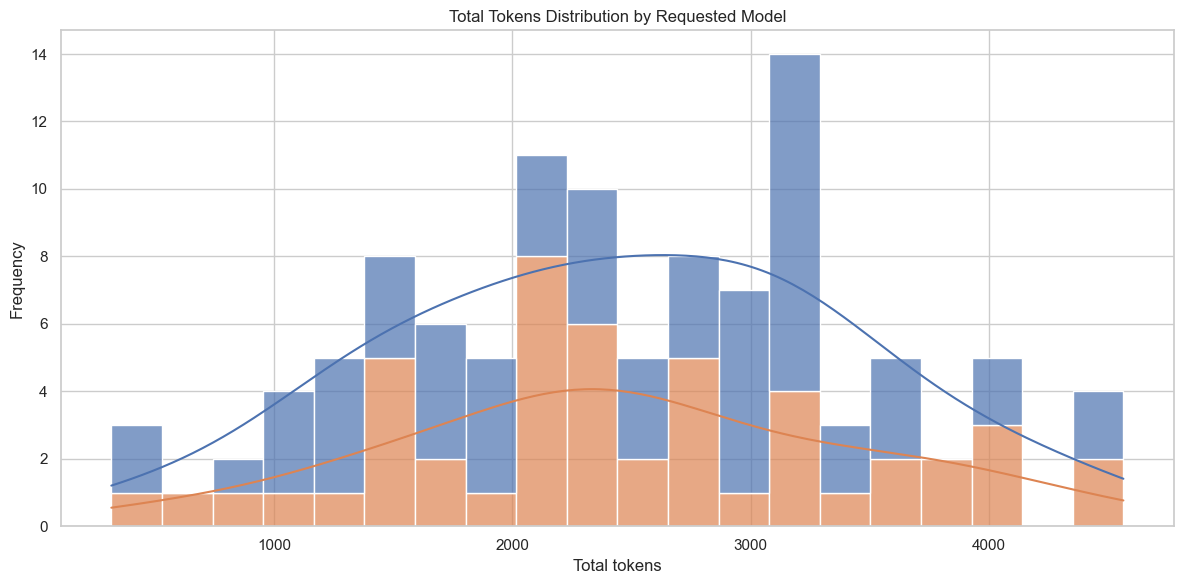

In [79]:
if not df_tokens.empty:
    if 'requested_model' not in df_tokens.columns:
        print('`requested_model` column missing; cannot plot by requested model.')
    else:
        plot_df = df_tokens.copy()
        plot_df['requested_model'] = plot_df['requested_model'].fillna('Unknown requested model')
        plt.figure(figsize=(12, 6))
        ax = sns.histplot(
            data=plot_df,
            x='usage.total_tokens',
            hue='requested_model',
            multiple='stack',
            bins=20,
            kde=True,
            alpha=0.7,
        )
        plt.title('Total Tokens Distribution by Requested Model')
        plt.xlabel('Total tokens')
        plt.ylabel('Frequency')

        handles, labels = ax.get_legend_handles_labels()
        legend_items = []
        seen = set()
        for handle, label in zip(handles, labels):
            if not label or label == 'requested_model' or label in seen:
                continue
            seen.add(label)
            legend_items.append((handle, label))

        if legend_items:
            ax.legend(
                [handle for handle, _ in legend_items],
                [label for _, label in legend_items],
                title='Requested model',
                bbox_to_anchor=(1.05, 1),
                loc='upper left',
            )
        elif ax.get_legend() is not None:
            ax.get_legend().remove()

        plt.tight_layout()
else:
    print('No token data to plot.')



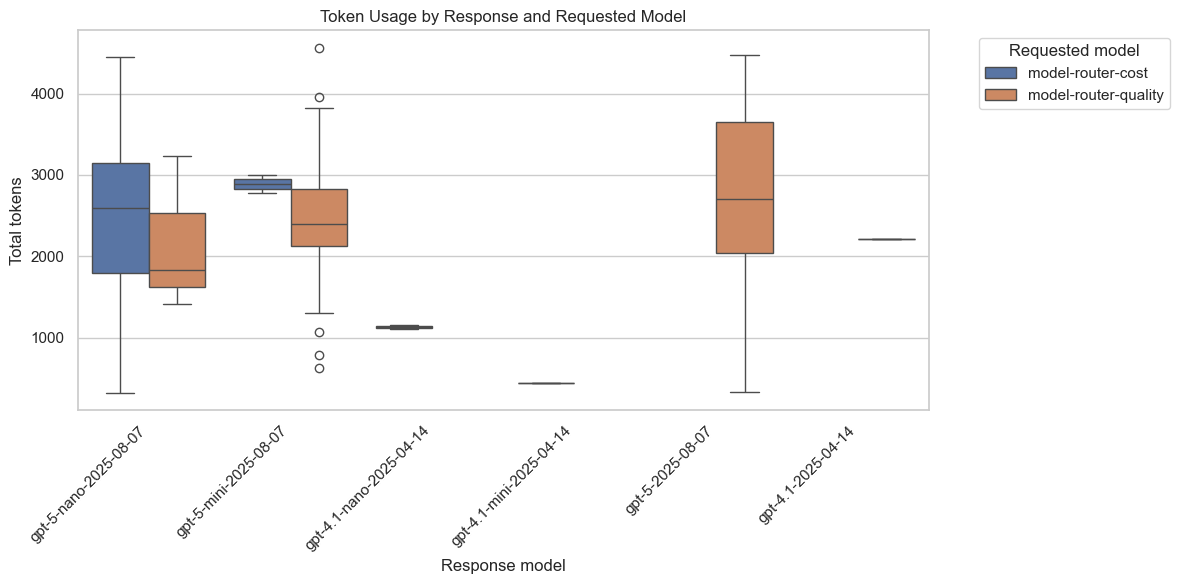

In [80]:
if not df_tokens.empty:
    if 'requested_model' not in df_tokens.columns:
        print('`requested_model` column missing; cannot plot by requested model.')
    else:
        plot_df = df_tokens.copy()
        plot_df['requested_model'] = plot_df['requested_model'].fillna('Unknown requested model')
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=plot_df,
            x='response_model',
            y='usage.total_tokens',
            hue='requested_model'
        )
        plt.title('Token Usage by Response and Requested Model')
        plt.xlabel('Response model')
        plt.ylabel('Total tokens')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Requested model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
else:
    print('No token data to plot.')



### Requested vs Response Token Scatter
Plot every run using prompt tokens (x) vs completion tokens (y), coloring by requested model and sizing by response model.


In [ ]:
if df_tokens.empty:
    print('No token data to plot.')
else:
    required_cols = [
        'requested_model',
        'response_model',
        'usage.prompt_tokens',
        'usage.completion_tokens',
    ]
    missing = [col for col in required_cols if col not in df_tokens.columns]
    if missing:
        print('Missing columns for scatter:', ', '.join(missing))
    else:
        runs = df_tokens.dropna(subset=['usage.prompt_tokens', 'usage.completion_tokens']).copy()
        if runs.empty:
            print('Insufficient data for requested/response scatter plot.')
        else:
            runs['requested_model'] = runs['requested_model'].fillna('Unknown requested model')
            runs['response_model'] = runs['response_model'].fillna('Unknown response model')

            response_levels = sorted(runs['response_model'].unique())
            min_size, max_size = 60, 400
            if len(response_levels) == 1:
                size_lookup = {response_levels[0]: (min_size + max_size) / 2}
            else:
                step = (max_size - min_size) / (len(response_levels) - 1)
                size_lookup = {level: min_size + idx * step for idx, level in enumerate(response_levels)}

            g = sns.relplot(
                kind='scatter',
                data=runs,
                x='usage.prompt_tokens',
                y='usage.completion_tokens',
                hue='requested_model',
                size='response_model',
                sizes=size_lookup,
                alpha=0.7,
                height=6,
                aspect=1.4,
            )
            g.set(
                title='Requested (color) vs Response (size) Tokens per Run',
                xlabel='Prompt tokens',
                ylabel='Completion tokens',
            )
            for label in g.ax.get_xticklabels():
                label.set_rotation(45)
                label.set_horizontalalignment('right')
            g.tight_layout()




In [83]:
if 'response' in df:
    df['response_length'] = df['response'].fillna('').apply(len)
    top_responses = df.sort_values('response_length', ascending=False)[
        ['input_id', 'requested_model', 'response_model', 'response_length', 'source_file']
    ].head(10)
    display(top_responses)
else:
    print('No response text available.')


,input_id,requested_model,response_model,response_length,source_file
88,30,model-router-quality,gpt-5-mini-2025-08-07,16701,batch_results_20251120_140429.jsonl
39,30,model-router-cost,gpt-5-nano-2025-08-07,15879,batch_results_20251120_123548.jsonl
65,7,model-router-quality,gpt-5-mini-2025-08-07,15774,batch_results_20251120_140429.jsonl
43,34,model-router-cost,gpt-5-nano-2025-08-07,14982,batch_results_20251120_123548.jsonl
89,31,model-router-quality,gpt-5-mini-2025-08-07,14871,batch_results_20251120_140429.jsonl
71,13,model-router-quality,gpt-5-mini-2025-08-07,14823,batch_results_20251120_140429.jsonl
26,17,model-router-cost,gpt-5-nano-2025-08-07,13990,batch_results_20251120_123548.jsonl
105,47,model-router-quality,gpt-5-mini-2025-08-07,13899,batch_results_20251120_140429.jsonl
16,7,model-router-cost,gpt-5-nano-2025-08-07,13664,batch_results_20251120_123548.jsonl
57,48,model-router-cost,gpt-5-nano-2025-08-07,13273,batch_results_20251120_123548.jsonl
